<a href="https://colab.research.google.com/github/makaishi2/dl-math-v2-doc/blob/main/notebooks/8_bi_classify_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# PDF印刷用
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

try:
    from google.colab import files
except:
    pass

pdf_ind = 2
pdf_base = 'pdf-01-'

def create_pdf():
    global pdf_ind, pdf_base
    fn = f'{pdf_base}{pdf_ind:02d}.pdf'
    print(fn)
    plt.rcParams['figure.subplot.bottom'] = 0.15
    plt.rcParams['figure.subplot.left'] = 0.15
    plt.savefig(fn)
    try:
        files.download(fn)
    except:
        pass
    pdf_ind = pdf_ind + 1

### 8章　二値ロジスティック回帰

### 環境準備

#### ライブラリ導入

In [2]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 48.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


#### ライブラリインポート

In [3]:
# ライブラリインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display
from sklearn.datasets import load_iris
import warnings

#### 環境設定

In [4]:
# 環境設定
np.set_printoptions(formatter={'float': '{:0.3f}'.format})
pd.options.display.float_format = '{:.3f}'.format
warnings.filterwarnings('ignore')

### データ読み込み

#### 読み込み関数

In [5]:
# 読み込み関数
def load_iris_dataset():
    iris = load_iris(as_frame=True)
    df = iris.data.copy()
    df.columns = ['がく片長', 'がく片幅', '花弁長', '花弁幅']
    df['品種'] = iris.target.map({0:'setosa', 1:'versicolor', 2:'virginica'})
    print(f"データ読み込み完了 ({df.shape[0]}件, 特徴量4)")
    return df, iris

#### 読み込み

In [6]:
# 読み込み
df, iris = load_iris_dataset()


データ読み込み完了 (150件, 特徴量4)


#### 内容確認

In [7]:
# 内容確認

# 先頭5行表示
display(df.head())

,がく片長,がく片幅,花弁長,花弁幅,品種
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa


### データ加工

#### 2クラスのみ抽出

In [8]:
# 2クラスのみ抽出
# 先頭の100行が2クラス分のデータになっていることを利用

# x_dataは、更に列についても2列の絞り込みを行う
x_data = df[['がく片長', 'がく片幅']].head(100)
y_data = iris.target[:100].values

# x_dataとy_dataのshape確認
print(f"x_data.shape: {x_data.shape}")
print(f"y_data.shape: {y_data.shape}")

x_data.shape: (100, 2)
y_data.shape: (100,)


#### ダミー変数追加

In [9]:
# ダミー変数追加
x_data2 = np.insert(x_data, 0, 1.0, axis=1)

# shape確認
print(f"x_data2.shape = {x_data2.shape}")

# 先頭5行のデータ確認
display(x_data2[:5])

x_data2.shape = (100, 3)


array([[1.000, 5.100, 3.500],
       [1.000, 4.900, 3.000],
       [1.000, 4.700, 3.200],
       [1.000, 4.600, 3.100],
       [1.000, 5.000, 3.600]])

#### 訓練データとテストデータの分割

In [10]:
# 訓練データとテストデータの分割

# データ分割用のライブラリ関数インポート
from sklearn.model_selection import train_test_split

# データ分割の実施
x_train, x_test, y_train, y_test = train_test_split(
    x_data2, y_data, train_size=70, test_size=30, random_state=123)

# 分割後の各変数のshape確認
print(f"x_train.shape: {x_train.shape}")
print(f"x_test.shape : {x_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape : {y_test.shape}")

x_train.shape: (70, 3)
x_test.shape : (30, 3)
y_train.shape: (70,)
y_test.shape : (30,)


#### 散布図表示(訓練データ)

pdf-01-02.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

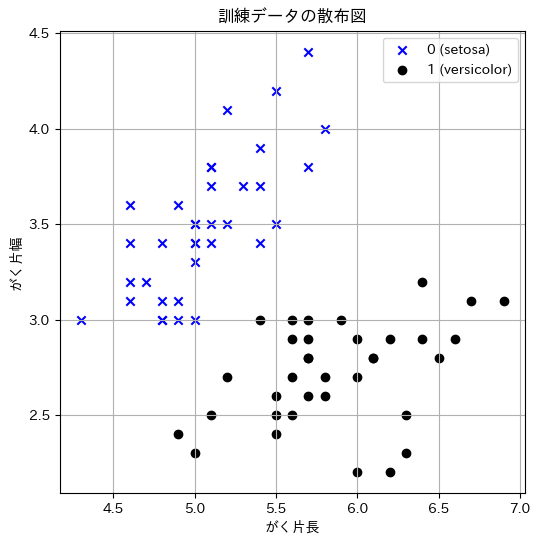

In [25]:
# 散布図表示(訓練データ)

# 正解値によるデータ分割
x_t0 = x_train[y_train==0]
x_t1 = x_train[y_train==1]

# 散布図表示
plt.figure(figsize=(6,6))
plt.scatter(x_t0[:,1], x_t0[:,2], marker='x', c='b', label='0 (setosa)')
plt.scatter(x_t1[:,1], x_t1[:,2], marker='o', c='k', label='1 (versicolor)')
plt.title('訓練データの散布図')
plt.xlabel('がく片長')
plt.ylabel('がく片幅')
plt.legend()
plt.grid(True)
create_pdf()
plt.show()

### 基本関数定義

#### シグモイド関数

In [12]:
# シグモイド関数
def sigmoid(x):
    """シグモイド関数（確率出力）"""
    return 1 / (1 + np.exp(-x))

#### 予測関数

In [13]:
# 予測関数
def pred(x, w):
    """予測関数（確率を出力）"""
    return sigmoid(x @ w)

#### 交差エントロピー関数

In [14]:
# 交差エントロピー関数
def cross_entropy(yt, yp):
    """交差エントロピー損失"""

    # 個別データごとに交差エントロピーを計算
    ce = -(yt * np.log(yp) + (1 - yt) * np.log(1 - yp))

    # 全データの平均を取り戻り値とする
    return np.mean(ce)

#### クラス変換関数

In [15]:
# クラス変換関数
def classify(y):
    """確率→クラス（0 or 1）変換"""

    # 確率値と閾値(0.5)の比較で0/1を判定
    return np.where(y < 0.5, 0, 1)

#### 評価関数

In [16]:
# 評価関数
from sklearn.metrics import accuracy_score
def evaluate(xt, yt, w):
    """損失と精度を計算"""

    # 予測値の計算(確率値)
    yp = pred(xt, w)

    # 予測クラスの計算(0/1)
    yp_b = classify(yp)

    # 損失の計算(確率値を利用)
    loss = cross_entropy(yt, yp)

    # 精度の計算(予測クラスを利用)
    score = accuracy_score(yt, yp_b)

    # 損失と精度を戻す
    return loss, score

### 学習

#### 学習関数

In [28]:
# 学習関数
def train_logistic_regression(x, yt, x_test, y_test, \
    alpha=0.01, iters=5000, his_unit=100):
    # M(データ件数)とD(入力データ要素数)の設定
    M, D = x.shape
    # 重みベクトル初期化(全要素1を設定)
    w = np.ones(D)
    # 学習過程記録用
    history = np.zeros((0,3))

    # 繰り返し処理
    for k in range(iters):
        # 予測計算
        yp = pred(x, w)
        # 誤差計算
        yd = yp - yt
        # 勾配計算
        grad = (x.T @ yd) / M
        # パラメータ修正
        w -=  alpha * grad

        if k % his_unit == 0:
            loss, score = evaluate(x_test, y_test, w)
            history = np.vstack((history, np.array([k, loss, score])))
            print(f"iter={k:5d} | loss={loss:.6f} | score={score:.6f}")
    return w, history

#### 学習

In [29]:
# 学習

# 学習用変数設定
x, yt = x_train, y_train

# 学習率と繰り返し回数の設定
alpha = 0.01
iters = 5000
his_unit = 100

# 繰り返し処理
w, history = train_logistic_regression(x, yt, \
    x_test, y_test, alpha=alpha, iters=iters, his_unit=his_unit)

iter=    0 | loss=4.493842 | score=0.500000
iter=  100 | loss=0.740979 | score=0.133333
iter=  200 | loss=0.677493 | score=0.700000
iter=  300 | loss=0.623544 | score=0.900000
iter=  400 | loss=0.577616 | score=0.933333
iter=  500 | loss=0.538328 | score=0.933333
iter=  600 | loss=0.504523 | score=0.933333
iter=  700 | loss=0.475249 | score=0.933333
iter=  800 | loss=0.449733 | score=0.933333
iter=  900 | loss=0.427348 | score=0.966667
iter= 1000 | loss=0.407587 | score=0.966667
iter= 1100 | loss=0.390041 | score=0.966667
iter= 1200 | loss=0.374373 | score=0.966667
iter= 1300 | loss=0.360310 | score=0.966667
iter= 1400 | loss=0.347626 | score=0.966667
iter= 1500 | loss=0.336133 | score=0.966667
iter= 1600 | loss=0.325677 | score=0.966667
iter= 1700 | loss=0.316126 | score=0.966667
iter= 1800 | loss=0.307370 | score=0.966667
iter= 1900 | loss=0.299316 | score=0.966667
iter= 2000 | loss=0.291885 | score=0.966667
iter= 2100 | loss=0.285007 | score=0.966667
iter= 2200 | loss=0.278624 | sco

### 結果分析

#### 損失と精度の確認

In [19]:
# 損失と精度の確認
print(f"初期状態: 損失={history[0,1]:.6f}, 精度={history[0,2]:.6f}")
print(f"最終状態: 損失={history[-1,1]:.6f}, 精度={history[-1,2]:.6f}")

初期状態: 損失=4.493842, 精度=0.500000
最終状態: 損失=0.194710, 精度=0.966667


#### 学習曲線(損失)

pdf-01-03.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

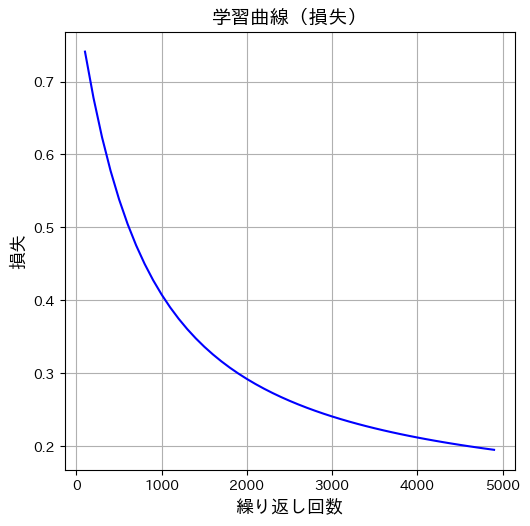

In [30]:
# 学習曲線(損失)
plt.figure(figsize=(6,6))
plt.plot(history[1:,0], history[1:,1], color='blue')
plt.title('学習曲線（損失）', fontsize=14)
plt.xlabel('繰り返し回数', fontsize=13)
plt.ylabel('損失', fontsize=13)
plt.grid(True)
create_pdf()
plt.show()

#### 学習曲線(精度)

pdf-01-04.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

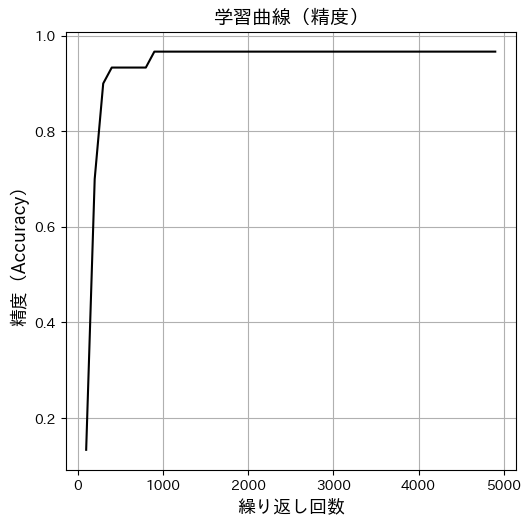

In [33]:
# 学習曲線(精度)
plt.figure(figsize=(6,6))
plt.plot(history[1:,0], history[1:,2], color='black')
plt.title('学習曲線（精度）', fontsize=14)
plt.xlabel('繰り返し回数', fontsize=13)
plt.ylabel('精度（Accuracy）', fontsize=13)
plt.grid(True)
create_pdf()
plt.show()

#### 決定境界の計算

In [35]:
#  決定境界の計算
def decision_boundary_x2(x1, w):
    """決定境界 x2 = -(w0 + w1*x1)/w2"""
    return -(w[0] + w[1]*x1) / w[2]

xl = np.array([x_test[:,1].min(), x_test[:,1].max()])
yl = decision_boundary_x2(xl, w)

#### 決定境界の可視化

pdf-01-06.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

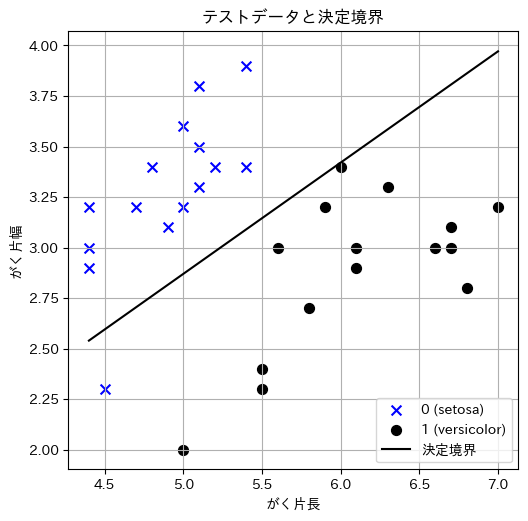

In [36]:
# 決定境界の可視化
x_t0 = x_test[y_test==0]
x_t1 = x_test[y_test==1]

plt.figure(figsize=(6,6))
plt.scatter(x_t0[:,1], x_t0[:,2], marker='x', c='b', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,1], x_t1[:,2], marker='o', c='k', s=50, label='1 (versicolor)')
plt.plot(xl, yl, c='k', label='決定境界')
plt.title('テストデータと決定境界')
plt.xlabel('がく片長')
plt.ylabel('がく片幅')
plt.legend()
plt.grid(True)
create_pdf()
plt.show()

#### 予測関数の3次元曲面表示

pdf-01-07.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

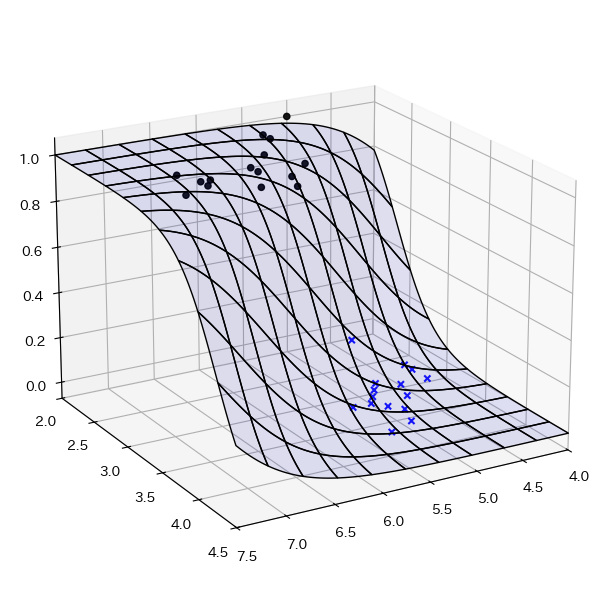

In [37]:
# 予測関数の3次元曲面表示

from mpl_toolkits.mplot3d import Axes3D
x1 = np.linspace(4, 7.5, 100)
x2 = np.linspace(2, 4.5, 100)
xx1, xx2 = np.meshgrid(x1, x2)
xxx = np.asarray([np.ones(xx1.ravel().shape),
    xx1.ravel(), xx2.ravel()]).T
c = pred(xxx, w).reshape(xx1.shape)
plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.plot_surface(xx1, xx2, c, color='blue',
    edgecolor='black', rstride=10, cstride=10, alpha=0.1)
ax.scatter(x_t0[:,1], x_t0[:,2], 0, s=20, alpha=0.9, marker='x', c='b')
ax.scatter(x_t1[:,1], x_t1[:,2], 1, s=20, alpha=0.9, marker='o', c='k')
ax.set_xlim(4,7.5)
ax.set_ylim(2,4.5)
ax.view_init(elev=20, azim=60)
create_pdf()

### scikit-learn ライブラリとの比較

#### 必要ライブラリのロード

In [38]:
# 必要ライブラリのロード
from sklearn.linear_model import LogisticRegression
from sklearn import svm

#### モデル生成

In [40]:
# モデル生成
model_lr = LogisticRegression(solver='liblinear')
model_svm = svm.SVC(kernel='linear')

#### 学習

In [41]:
# 学習
model_lr.fit(x, yt)
model_svm.fit(x, yt)

SVC(kernel='linear')

#### 線形回帰の決定直線

In [42]:
# 線形回帰の決定直接
# 切片の値
lr_w0 = model_lr.intercept_[0]
# x1(sepal_length)の係数
lr_w1 = model_lr.coef_[0,1]
# x2(sepal_width)の係数
lr_w2 = model_lr.coef_[0,2]

def rl(x):
    wk = lr_w0 + lr_w1 * x
    wk2 = -wk / lr_w2
    return(wk2)

y_rl = rl(xl)

# 結果確認
print(xl, y_rl)

[4.400 7.000] [2.563 4.120]


#### SVMの決定直線

In [43]:
# SVMの決定直線
# 切片の値
svm_w0 = model_svm.intercept_[0]
# x1(sepal_length)の係数
svm_w1 = model_svm.coef_[0,1]
# x2(sepal_width)の係数
svm_w2 = model_svm.coef_[0,2]

def svm(x):
    wk = svm_w0 + svm_w1 * x
    wk2 = -wk / svm_w2
    return(wk2)

y_svm = svm(xl)

# 結果確認
print(xl,y_svm)

[4.400 7.000] [2.266 4.512]


#### 散布図と決定直線の同時表示

pdf-01-08.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

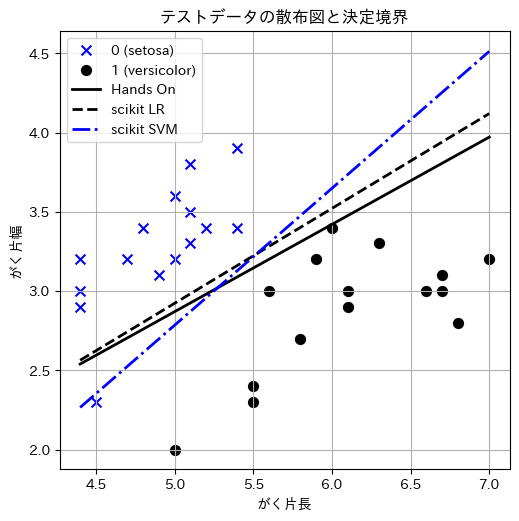

In [44]:
# 散布図と決定直線の同時表示

plt.figure(figsize=(6,6))

# 散布図の表示
plt.scatter(x_t0[:,1], x_t0[:,2], marker='x',c='b', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,1], x_t1[:,2], marker='o',c='k', s=50, label='1 (versicolor)')

# 決定直線の表示
plt.plot(xl, yl, linewidth=2, c='k', label='Hands On')
# lr model
plt.plot(xl, y_rl, linewidth=2, c='k', linestyle="--", label='scikit LR')
# svm
plt.plot(xl, y_svm, linewidth=2, c='b', linestyle="-.", label='scikit SVM')

# グラフのキレイ化
plt.title('テストデータの散布図と決定境界')
plt.xlabel('がく片長')
plt.ylabel('がく片幅')
plt.legend()
plt.grid()
create_pdf()
plt.show()

### バージョン確認

In [24]:
!pip install watermark -qq
%load_ext watermark
%watermark --iversions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.1 MB/s eta 0:00:00
numpy              : 2.0.2
matplotlib_inline  : 0.1.7
google             : 2.0.3
japanize_matplotlib: 1.1.3
IPython            : 7.34.0
sklearn            : 1.6.1
pandas             : 2.2.2
matplotlib         : 3.10.0

